## Question 4: Energy-based Models

- make a simple energy-based model (exp^-NN).
- train and use Gibbs sampling method on USPS.

## Quick Notes

I used a simple MLP as the energy model. 

Note that I did not apply Gibbs sampling as the condition are hard (unlikely) to model because I use a simple MLP model. Instead, I used Matropolis-Hasting algorithm, which can be considered as a variant of Gibbs sampling. 

## Data Preparation

I download USPS dataset from https://github.com/darshanbagul/USPS_Digit_Classification/blob/master/USPSdata/USPSdata.zip and unzip to 'data/' folder

In [ ]:
# Import pacakges
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms
import itertools
import matplotlib.pyplot as plt
from functools import partial
import datetime
import os
import glob
import cv2
import tqdm

In [ ]:
# Data preparation
if not os.path.exists("data/Numerals"):
    raise Exception("USPS data not found, please download the raw dataset from https://github.com/darshanbagul/USPS_Digit_Classification/blob/master/USPSdata/USPSdata.zip and unzip to 'data/' folder")

In [109]:
# Process dataset
def process_data(dir, size):
    def resize_and_scale(img, size, scale):
        img = cv2.resize(img, size)
        return 1 - np.array(img, "float32")/scale

    images = glob.glob(os.path.join(dir, "*", "*.png"))
    res = []
    for img_path in tqdm.tqdm(images, desc='Processing USPS images'):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resized_img = resize_and_scale(img, size, 256)
        res.append(np.expand_dims(resized_img, axis = 0))
    return res


size = (28,28)
images = process_data("data/Numerals", size)

Processing USPS images:   0%|          | 0/19999 [00:00<?, ?it/s]

Processing USPS images: 100%|██████████| 19999/19999 [00:14<00:00, 1352.46it/s]


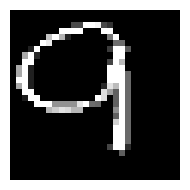

In [111]:
images[0].shape

plt.figure(figsize=(2,2))
plt.imshow(images[12000].squeeze(), cmap='gray')
plt.axis('off')  # Optional: hide axes
plt.tight_layout()
plt.show()

In [112]:
# Set the random seeds
torch.manual_seed(0)
np.random.seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
print("device:", device)

device: cuda:4


In [113]:
EMBEDDING_DIM = 20 # The dimension of the embeddings

class AutoEncoder(nn.Module):
    """
    A simple autoencoder for images. 
    self.linear1 generates the intermediate embeddings that we use for the normalizing flow.
    """
    def __init__(self):
        super().__init__()
        
        # Encoding layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, stride=2, kernel_size=3, bias=False, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, stride=2, kernel_size=3, bias=False, padding=1)
        self.linear1 = nn.Linear(in_features=3136, out_features=EMBEDDING_DIM)
        
        # Decoding layers
        self.linear2 = nn.Linear(in_features=EMBEDDING_DIM, out_features=3136)
        self.convt1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, stride=2, kernel_size=3, padding=1, output_padding=1)
        self.convt2 = nn.ConvTranspose2d(in_channels=32, out_channels=1, stride=2, kernel_size=3, padding=1, output_padding=1)


    def forward(self, x):
        
        emb = self.encoder(x)
        _x = self.decoder(emb)
        
        return _x, emb
    
    def decoder(self, emb):

        _x = torch.relu(self.linear2(emb))
        _x = _x.view(-1, 64, 7, 7)
        _x = torch.relu(self.convt1(_x))
        _x = self.convt2(_x)
        
        return _x
    
    def encoder(self, x):
        _x = torch.relu(self.conv1(x))
        _x = torch.relu(self.conv2(_x))
        sh = _x.shape

        _x = torch.relu(torch.flatten(_x, 1))
        
        emb = self.linear1(_x)
        
        return emb

In [114]:
BATCH_SIZE = 100 # Batch size
# Load the dataset
train_loader = torch.utils.data.DataLoader(images, BATCH_SIZE)

In [123]:
AE_EPOCHS = 20 # Epochs for training the autoencoder
# We use a binary cross-entropy loss for the reconstruction error
loss_f = nn.BCELoss()

# Build the autoencoder
autoencoder = AutoEncoder()
autoencoder = autoencoder.to(device)

optimizer = torch.optim.Adam(itertools.chain(autoencoder.parameters()),
                             lr=1e-3, weight_decay=1e-5)

In [124]:
for i in range(AE_EPOCHS):
    print('Epoch #{}'.format(i+1))

    losses = []
    for batch_idx, data in enumerate(train_loader):

        x = data
        x = x.to(device)

        # Run the autoencoder
        _x, emb = autoencoder(x)
        _x = torch.sigmoid(_x)

        # Compute loss
        rec_loss = loss_f(_x, x)

        if batch_idx % 200 == 0:
            print(f"E {i}, {batch_idx:.3f}/{len(train_loader)}: Loss: {rec_loss.item()}")

        autoencoder.zero_grad()
        rec_loss.backward()
        optimizer.step()

Epoch #1
E 0, 0.000/200: Loss: 0.6689754724502563
Epoch #2
E 1, 0.000/200: Loss: 0.3634474277496338
Epoch #3
E 2, 0.000/200: Loss: 0.2710687518119812
Epoch #4
E 3, 0.000/200: Loss: 0.2175598442554474
Epoch #5
E 4, 0.000/200: Loss: 0.19338959455490112
Epoch #6
E 5, 0.000/200: Loss: 0.17870816588401794
Epoch #7
E 6, 0.000/200: Loss: 0.1705603003501892
Epoch #8
E 7, 0.000/200: Loss: 0.16525226831436157
Epoch #9
E 8, 0.000/200: Loss: 0.16073068976402283
Epoch #10
E 9, 0.000/200: Loss: 0.1568240225315094
Epoch #11
E 10, 0.000/200: Loss: 0.15362133085727692
Epoch #12
E 11, 0.000/200: Loss: 0.15090644359588623
Epoch #13
E 12, 0.000/200: Loss: 0.1487240195274353
Epoch #14
E 13, 0.000/200: Loss: 0.1468474119901657
Epoch #15
E 14, 0.000/200: Loss: 0.14517652988433838
Epoch #16
E 15, 0.000/200: Loss: 0.14390191435813904
Epoch #17
E 16, 0.000/200: Loss: 0.14273639023303986
Epoch #18
E 17, 0.000/200: Loss: 0.14192190766334534
Epoch #19
E 18, 0.000/200: Loss: 0.14117185771465302
Epoch #20
E 19, 0.00

In [ ]:

torch.save(autoencoder.state_dict(), "autoencoder.pth")
# autoencoder.load_state_dict(torch.load("autoencoder.pth", map_location='cpu'))

torch.Size([1, 1, 28, 28])


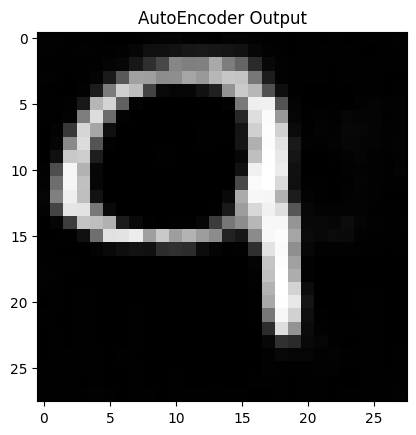

In [126]:
test_image = torch.from_numpy(images[12000]).unsqueeze(0)
test_image = test_image.to(device)
_o, emb = autoencoder(test_image)
_o = torch.sigmoid(_o)
print(_o.shape)

## Display the image
plt.imshow(_o.squeeze().detach().cpu(), cmap='gray');
plt.title("AutoEncoder Output");

In [128]:
## 1. Extract all the data to embeddings
import tqdm

embs = []
with torch.no_grad():
    for data in tqdm.tqdm(train_loader):
        x  = data
        x = x.to(device)

        emb = autoencoder.encoder(x).cpu()
        for e in emb:
            embs.append(e)

print(len(embs))

100%|██████████| 200/200 [00:00<00:00, 851.10it/s]

19999


In [130]:
BATCH_SIZE=30
emb_dataset = torch.utils.data.DataLoader(embs, batch_size=BATCH_SIZE, shuffle = True)

In [131]:
## Energy Models

class MLP(nn.Module):
    def __init__(self, input_dim=20, hidden_dims=[256, 128], output_dim=1): # the output dimension has to be 1d
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = F.silu(self.fc1(x))
        x = F.silu(self.fc2(x))
        x = self.fc3(x)  # logits for classification
        return x

In [132]:
model = MLP()
x = torch.randn([2, 20])
out = model(x)
out.shape

torch.Size([2, 1])

In [ ]:
import time

def matropolis_sampling(x, log_prob, n_steps, n_sample_out, var):

    def _sample_next(x, var):
        # x: numpy 1d 
        return torch.randn(x.shape[0], device=x.device) * np.sqrt(var) + x
    

    res = []
    for _ in range(n_steps):
        x_next = _sample_next(x, var)
        accept_prob_log = min(0, (log_prob(x_next) - log_prob(x)).item())
        if torch.log(torch.rand(1)).item() < accept_prob_log:
            x = x_next
        res.append(x)
    return torch.stack(res, axis = 0)[-n_sample_out:]
    

def train_energy_model(model, optimizer, sample_fn, epoch = 10, device=device, log_interval = 100):
    model.to(device)
    for e in range(epoch):
        print(f"[Epoch {e}]")
        start = time.time()
        for bb, data in enumerate(emb_dataset):
            data = data.to(device)
            real_output = model(data).mean() # tensor()
            x_sample = sample_fn(torch.randn(data.shape[-1], device = device), log_prob = lambda x: -model(x)) # [B', 20]
            est_output = model(x_sample).mean() # tensor()
            loss = real_output - est_output
            model.zero_grad()
            loss.backward()
            optimizer.step()

            if bb % log_interval == 0:
                print(f"[Epoch {e}] | [{bb}|{len(emb_dataset)}] loss: {loss.item()}, est epoch: {datetime.timedelta(seconds=(len(emb_dataset) -1 - bb) / log_interval * (time.time() - start))}")
                start = time.time()
    pass

In [139]:
model = MLP()
optimizer = torch.optim.Adam(model.parameters(), lr = 1.0e-3)

sample_fn = partial(matropolis_sampling, n_steps = 300, n_sample_out = 50, var = 0.1)

out = sample_fn(x = torch.randn(20), log_prob = model)
out.shape
# if os.path.exists('energy_mlp_model.pth'):
#     model.load_state_dict(torch.load('energy_mlp_model.pth', map_location='cpu'))
# else:
train_energy_model(model, optimizer, sample_fn, epoch = 3, device=device)
torch.save(model.state_dict(), 'energy_mlp_model.pth')

[Epoch 0]
[Epoch 0] | [0|667] loss: 0.3361457586288452, est epoch: 0:00:01.515672
[Epoch 0] | [100|667] loss: -5.405837059020996, est epoch: 0:01:52.179416
[Epoch 0] | [200|667] loss: 0.24352741241455078, est epoch: 0:01:32.543386
[Epoch 0] | [300|667] loss: -1.3397431373596191, est epoch: 0:01:13.173069
[Epoch 0] | [400|667] loss: 1.1223125457763672, est epoch: 0:00:53.383936
[Epoch 0] | [500|667] loss: 1.663149118423462, est epoch: 0:00:33.129432
[Epoch 0] | [600|667] loss: -3.5593321323394775, est epoch: 0:00:13.277873
[Epoch 1]
[Epoch 1] | [0|667] loss: -2.4365744590759277, est epoch: 0:00:01.352557
[Epoch 1] | [100|667] loss: -5.457645416259766, est epoch: 0:01:53.585469
[Epoch 1] | [200|667] loss: 1.8958981037139893, est epoch: 0:01:35.247466
[Epoch 1] | [300|667] loss: 0.4420003890991211, est epoch: 0:01:14.567428
[Epoch 1] | [400|667] loss: -0.6683163642883301, est epoch: 0:00:54.915293
[Epoch 1] | [500|667] loss: -1.1437411308288574, est epoch: 0:00:33.960104
[Epoch 1] | [600|

In [142]:
@torch.no_grad()
def sample_plot(n_sample, autoencoder, model, sample_fn, index):
    def _plot_image_row(row_images, titles=None, cmap='gray'):
        num_cols = len(row_images)
        fig, axs = plt.subplots(1, num_cols, figsize=(2 * num_cols, 2))

        # Ensure axs is iterable
        if num_cols == 1:
            axs = [axs]

        for j, img in enumerate(row_images):
            axs[j].imshow(img, cmap=cmap)
            axs[j].axis('off')
            if titles and j < len(titles):
                axs[j].set_title(titles[j])

        plt.tight_layout()
        plt.show()
        plt.close(fig)
    
    for _ in range(n_sample):
        out = sample_fn(x = torch.randn(20, device = device), log_prob= lambda x: -model(x))
        out = autoencoder.decoder(out)
        out = torch.sigmoid(out)
        _plot_image_row(out[index].cpu().numpy().squeeze(), titles=['step=' + str(i) for i in index])

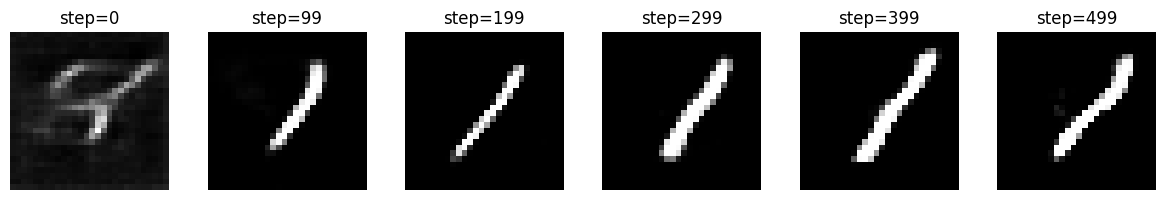

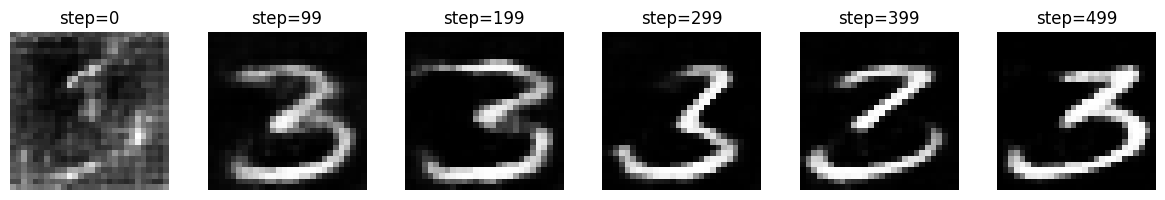

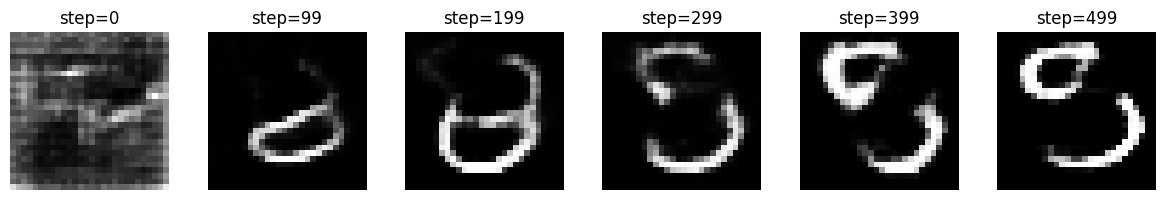

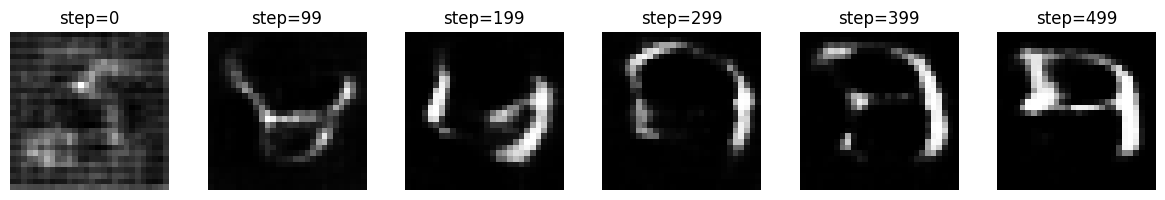

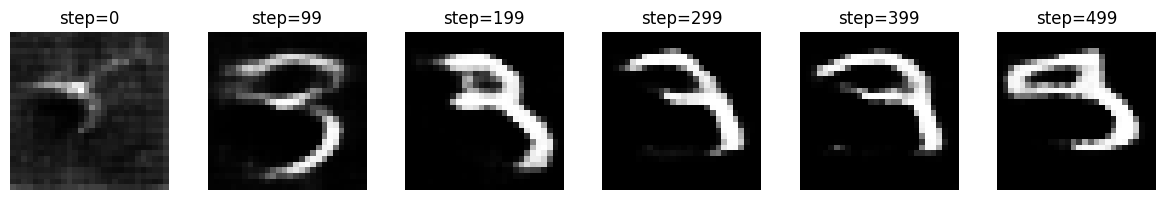

In [143]:
model.to(device)
sample_fn = partial(matropolis_sampling, n_steps = 500, n_sample_out = 500, var = 0.2)
sample_plot(5, autoencoder, model, sample_fn, index=[0, 99, 199, 299, 399, 499])